<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/__draft___pixel_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

fatal: destination path 'nn_hallucinations' already exists and is not an empty directory.


In [33]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from torchvision import datasets

In [35]:
BATCH_SIZE = 32
TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    lambda x: distributions.Bernoulli(probs=x).sample()])

train_loader = data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=TRANSFORM),
    batch_size=BATCH_SIZE, 
    shuffle=True)
test_loader = data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,transform=TRANSFORM),
    batch_size=BATCH_SIZE*2)

In [36]:
class MaskedConv2d(nn.Conv2d):

  EXCLUDE_SELF = 0
  INCLUDE_SELF = 1

  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)

    i, o, h, w = self.weight.shape
    # TODO(eugenhotaj): Will this masking logic work correctly for even kernel 
    # sizes? If not, maybe we should raise an exception instead.
    mask = torch.zeros((i, o, h, w))
    mask.data[:, :, :h//2, :] = 1
    mask.data[:, :, h//2, :w//2 + mask_type] = 1
    self.register_buffer('mask', mask)

  def forward(self, x):
    return self._conv_forward(x, self.weight * self.mask)

    
class MaskedResidualBlock(nn.Module):
  
  def __init__(self, n_channels):
    super().__init__()
    self._net = nn.Sequential(
        # NOTE(eugenhotaj): The PixelCNN paper users Relu->Conv2d since they do
        # not use a ReLU in the first layer. We instead use Conv2d->ReLU as is 
        # traditionally done.
        nn.Conv2d(in_channels=n_channels, 
                  out_channels=n_channels//2, 
                  kernel_size=1),
        nn.ReLU(),
        MaskedConv2d(mask_type=MaskedConv2d.INCLUDE_SELF,
                     in_channels=n_channels//2,
                     out_channels=n_channels//2,
                     kernel_size=3,
                     padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=n_channels//2, 
                  out_channels=n_channels,
                  kernel_size=1),
        nn.ReLU())

  def forward(self, x):
    return x + self._net(x)


class PixelCNN(nn.Module):

  def __init__(self, 
               in_channels, 
               residual_channels=16, 
               head_channels=32,
               n_residual_blocks=4):
    """Initializes a new PixelCNN instance.
    
    Args:
      in_channels: The number of channels in the input image (typically either 
        1 or 3 for black and white or color images respectively).
      residual_channels: The number of channels to use in the residual layers.
        This corresponds to the 'h' parameter in the van den Oord et al. (2016)
        paper.
      head_channels: The number of channels to use in the two 1x1 convolutional
        layers at the head of the network.
      n_residual_blocks: The number of residual blocks to use.
    """

    super().__init__()

    layers = [
      MaskedConv2d(mask_type=MaskedConv2d.EXCLUDE_SELF,
                   in_channels=in_channels,
                   out_channels=2*residual_channels,
                   kernel_size=7,
                   padding=3)]
    for _ in range(n_residual_blocks):
      layers.append(MaskedResidualBlock(n_channels=2*residual_channels))
    # TODO(eugenhotaj): Do we even need the head channels?
    layers.extend([
        nn.Conv2d(in_channels=2*residual_channels, 
                  out_channels=head_channels, 
                  kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=head_channels, 
                  out_channels=in_channels, 
                  kernel_size=1),
        nn.Sigmoid()
    ])
    self._net = nn.Sequential(*layers)

  def forward(self, x):
    return self._net(x)

  def sample(self):
    """Samples a new image.
    
    Args:
      conditioned_on: An (optional) image to condition samples on. Only 
        dimensions with values < 0 will be sampled. For example, if 
        conditioned_on[i] = -1, then output[i] will be sampled conditioned on
        dimensions j < i. If 'None', an unconditional sample will be generated.
    """
    with torch.no_grad():
      device = next(self.parameters()).device
      conditioned_on = (torch.ones((1, 1,  28, 28)) * - 1).to(device)

      for channel in range(1):
        for row in range(28):
          for column in range(28):
            out = self.forward(conditioned_on)[:, channel, row, column]
            out = distributions.Bernoulli(probs=out).sample()
            conditioned_on[:, channel, row, column] = torch.where(
                conditioned_on[:, channel, row, column] < 0,
                out, 
                conditioned_on[:, channel, row, column])
      return conditioned_on

In [ ]:
IN_CHANNELS = 1
RESIDUAL_CHANNELS = 16
HEAD_CHANNELS = 32
N_RESIDUAL_BLOCKS = 12

N_EPOCHS = 50

torch.cuda.empty_cache()
model = PixelCNN(IN_CHANNELS, 
                 RESIDUAL_CHANNELS, 
                 HEAD_CHANNELS, 
                 N_RESIDUAL_BLOCKS).to(colab_utils.get_device())
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')

def loss_fn(x, _, preds):
  batch_size = x.shape[0]
  x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1))
  return bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model, 
    loss_fn, 
    optimizer=optimizer, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader,
    eval_loader=test_loader,
    device=colab_utils.get_device())

[1|1584]: train_loss=103.70847060139974 eval_loss=94.7679193359375
[2|1586]: train_loss=93.91551056315105 eval_loss=92.9171821899414
[3|1559]: train_loss=92.93195971272786 eval_loss=91.75038044433593


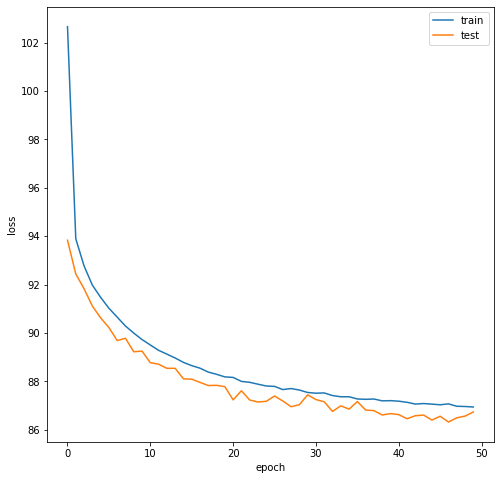

In [ ]:
epochs = len(train_losses)
plt.figure(figsize=(8, 8))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), eval_losses)
plt.legend(['train', 'test'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
def show_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].unsqueeze(0).to(colab_utils.get_device())
  img_hat = model(img)
  colab_utils.imshow(img.reshape(28, 28))
  colab_utils.imshow(img_hat.reshape(28, 28))


def sample(model):
  colab_utils.imshow(model.sample().reshape(28, 28))


def conditional_sample_random(model, dataset):
  idx = np.random.choice(len(dataset))
  img = dataset[idx][0].reshape(1, -1).to(colab_utils.get_device())
  img[0, 300:600] = -1
  colab_utils.imshow(img.reshape(28, 28))
  plt.show()
  print("Conditional Samples:")
  for i in range(5):
    img_hat = model.sample(img)
    colab_utils.imshow(img_hat.reshape(28, 28))

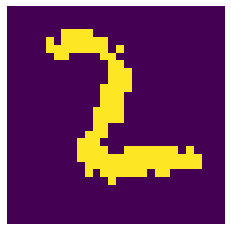

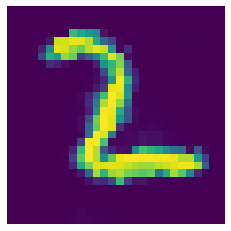

In [ ]:
show_random(model, test_loader.dataset)

In [ ]:
model_weights = model.state_dict()
model = PixelCNN(IN_CHANNELS, HIDDEN_CHANNELS, HEAD_CHANNELS).to(
    colab_utils.get_device())
model.load_state_dict(model_weights)

<All keys matched successfully>

In [ ]:
sample(model)